# 0. Preparación del entorno

In [20]:
import os

import uuid
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from google.colab import drive
from statsmodels.tsa.stattools import acf

In [21]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
os.environ['RUTA_SIMULACIONES'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/simulaciones/'
os.environ['RUTA_DATASETS'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/datasets/'
os.environ['DATASET_CONSUMOS'] = 'consumos_casas_1-99'
os.environ['MAX_HOUSE_LOAD'] = '99'

# 1. Arquitectura

## 1.2. Modelos

In [23]:
class Evento():
  def __init__(self, min_inicio: int, serie_evento: list[int] = None):
    if serie_evento is None:
      serie_evento = []
    self.id = str(uuid.uuid4())
    self.min_inicio = min_inicio
    self.min_fin = min_inicio + len(serie_evento)
    self._serie = serie_evento

  def ampliar_serie_con_valor(self, valor: int):
    self._serie.append(valor)
    self.min_fin += 1

  def ampliar_serie_con_serie(self, nueva_serie: list[int]):
    self._serie += nueva_serie
    self.min_fin += len(nueva_serie)

  def obtener_serie(self):
    return [*self._serie]

  def __dict__(self):
    return {
            'id': self.id,
            'min_inicio': self.min_inicio,
            'min_fin': self.min_fin,
            'serie': self._serie,
          }

In [24]:
class Consumo:
  def __init__(self, dia: int, casa: str, parte: int = 0, serie: list[int] = []):
    self.dia: int = dia
    self.casa: str = casa
    self.parte: int = parte
    self._serie: list[int] = serie
    self._descompuesto = False
    self._lista_eventos: list[Evento] = []

  def get_serie(self) -> list[int]:
    return [*self._serie]

  def leer_serie(self):
    self._serie = leer_consumo_excel(self.dia, self.casa, self.parte)

  def obtener_lista_eac(self, consumo_minimo: int = 8) -> list[Evento]:
    lista_eac = []
    for e in self.obtener_lista_eventos():
      if sum(e.obtener_serie()) >= consumo_minimo:
        lista_eac.append(e)
    return lista_eac

  def obtener_lista_ebc(self, consumo_maximo: int = 8) -> list[Evento]:
    lista_ebc = []
    for e in self.obtener_lista_eventos():
      if sum(e.obtener_serie()) <= consumo_maximo:
        lista_ebc.append(e)
    return lista_ebc

  def obtener_lista_eventos(self):
    if not self._descompuesto:
      evento = None

      for m, c in zip(range(len(self._serie)), self._serie):
        if c == 0:
          if not evento:
            continue
          else:
            self._lista_eventos.append(evento)
            evento = None
        elif c > 0:
          if not evento:
            evento = Evento(m)
          evento.ampliar_serie_con_valor(c)

      self._descompuesto = True
    return [*self._lista_eventos]

  def obtener_id(self) -> str:
    return f"{self.casa}_day{self.dia}_part{self.parte}"

In [25]:
class GrupoConsumos:
  def __init__(self):
    self._consumos: list[Consumo] = []
    self._n_consumos = 0

  def get_consumos(self) -> list[Consumo]:
    return [*self._consumos]

  def get_consumo(self, dia: int, casa: str, parte: int = 0) -> Consumo:
    return next((c for c in self._consumos if c.dia == dia and c.casa == casa and c.parte == parte), None)

  def add_consumo(self, consumo: Consumo):
    self._consumos.append(consumo)
    self._n_consumos += 1

  def guardar_como_excel(self, nombre_archivo: str = 'consumos_casas_1-100'):
    data = []
    for consumo in self._consumos:
      data.append({
        'dia': consumo.dia,
        'casa': consumo.casa,
        'parte': consumo.parte,
        'serie': consumo.get_serie()
      })
    df = pd.DataFrame(data)
    df.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=False)

  def carga_desde_excel(self, nombre_archivo: str):
    df = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx")
    self._consumos = []
    self._n_consumos = 0
    for _, row in df.iterrows():
      consumo = Consumo(row['dia'], row['casa'], row['parte'], eval(row['serie']))
      self.add_consumo(consumo)


## 1.1. Utils

### 1.1.1. Carga y procesamiento de datos de consumo

In [26]:
def obtener_ruta_archivo(nombre: str, parte: int = 0):
  ruta_archivo = f"{os.environ.get('RUTA_SIMULACIONES')}{nombre}"
  if parte != 0:
    ruta_archivo += f"_part{parte}"
  ruta_archivo += ".xlsx"
  return ruta_archivo

assert obtener_ruta_archivo("House1", 1) == os.environ.get('RUTA_SIMULACIONES') + 'House1_part1.xlsx'
assert obtener_ruta_archivo("House1", 0) == os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx'

In [27]:
def obtener_n_dias(ruta_archivo: str):
  xls = pd.ExcelFile(ruta_archivo)
  return len([d for d in xls.sheet_names if d.startswith('Day')]);

assert obtener_n_dias(os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx') == 10

In [28]:
def leer_consumo_excel(dia: int, casa: str, parte: int = 0):
  serie = pd.read_excel(obtener_ruta_archivo(casa, parte), sheet_name=f'Day{dia}', header=None).iloc[0]
  data = [int(x) for x in serie if not isinstance(x, str)]
  return data

### 1.1.2. Obtención de eventos

In [29]:
# def descomposicion_basica(consumo: Consumo):
#   serie = consumo.get_serie()
#   en_evento = False
#   eventos_extraidos = []
#   evento = None

#   for m, c in zip(range(len(serie)), serie):
#     if c == 0:
#       if not evento:
#         continue
#       else:
#         eventos_extraidos.append(evento)
#         evento = None
#     elif c > 0:
#       if not evento:
#         evento = Evento(m, consumo)
#       evento.ampliar_serie_con_valor(c)
#   return eventos_extraidos

In [30]:
# def obtener_eventos_de_alto_consumo(lista_eventos: list[Evento], consumo_minimo: int):
#   lista_eac = []
#   for e in lista_eventos:
#     if sum(e.obtener_serie()) > consumo_minimo:
#       lista_eac.append(e)
#   return lista_eac

In [31]:
def construir_serie_desde_eventos(lista_eventos: list[Evento], acotada: bool = True):
  if not lista_eventos:
    return [0] * 1440

  lista_eventos.sort(key=lambda evento: evento.min_inicio)
  ultimo_evento = lista_eventos[0]
  serie = [*ultimo_evento.obtener_serie()]

  for e in lista_eventos[1:]:
    if ultimo_evento.min_fin <= e.min_inicio:
      serie += [0] * (e.min_inicio - ultimo_evento.min_fin)
      serie += e.obtener_serie()
      ultimo_evento = e
    else:
      pass

  if not acotada:
    serie = [*([0] * lista_eventos[0].min_inicio), *serie, *([0] * (1440 - lista_eventos[::-1][0].min_fin))]

  return serie


### 1.1.3. Localización de eventos discontinuos

In [32]:
def calcular_autocorrelacion(serie: list[int], nlags: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = acf(serie, nlags=nlags, alpha=0.05)
  autocorrelacion = autocorrelacion[lags_offset:]
  intervalo_confianza = intervalo_confianza[lags_offset:]

  return (autocorrelacion, intervalo_confianza)

In [33]:
def calcular_umbral_lower(intervalo_confianza: np.array):
  lowers = []
  for lower, upper in intervalo_confianza:
    lowers.append(lower)

  media_lowers = np.mean(lowers)
  umbral_lower = media_lowers + np.std(lowers)
  return umbral_lower

In [34]:
def localizar_repeticiones(serie: list[int], min_inicio: int, umbral_separacion_ecd: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = calcular_autocorrelacion(serie, len(serie) - 1)
  umbral_lower = calcular_umbral_lower(intervalo_confianza)

  repeticiones = []
  distancia_ultima_repeticion = lags_offset - 1
  for lag, val, (lower, upper) in zip(range(lags_offset, len(autocorrelacion) + lags_offset), autocorrelacion, intervalo_confianza):
    distancia_ultima_repeticion += 1
    if lower > umbral_lower and distancia_ultima_repeticion > umbral_separacion_ecd:
      repeticiones.append((lag + min_inicio, distancia_ultima_repeticion))
      distancia_ultima_repeticion = 0

  return repeticiones


# X. Main

### Generación o lectura del dataset con todas las series temporales de consumo

In [35]:
consumos_simulados = GrupoConsumos()
dataset_consumos = os.environ.get('DATASET_CONSUMOS')

if dataset_consumos == '':
  for i in range(1, int(os.environ.get('MAX_HOUSE_LOAD')) + 1):
    casa = f"House{i}"
    for d in range(1, obtener_n_dias(obtener_ruta_archivo(casa)) + 1):
      consumo = Consumo(d, casa)
      consumo.leer_serie()
      consumos_simulados.add_consumo(consumo)
  consumos_simulados.guardar_como_excel(f"consumos_casas_1-{os.environ.get('MAX_HOUSE_LOAD')}")
else:
  consumos_simulados.carga_desde_excel(dataset_consumos)

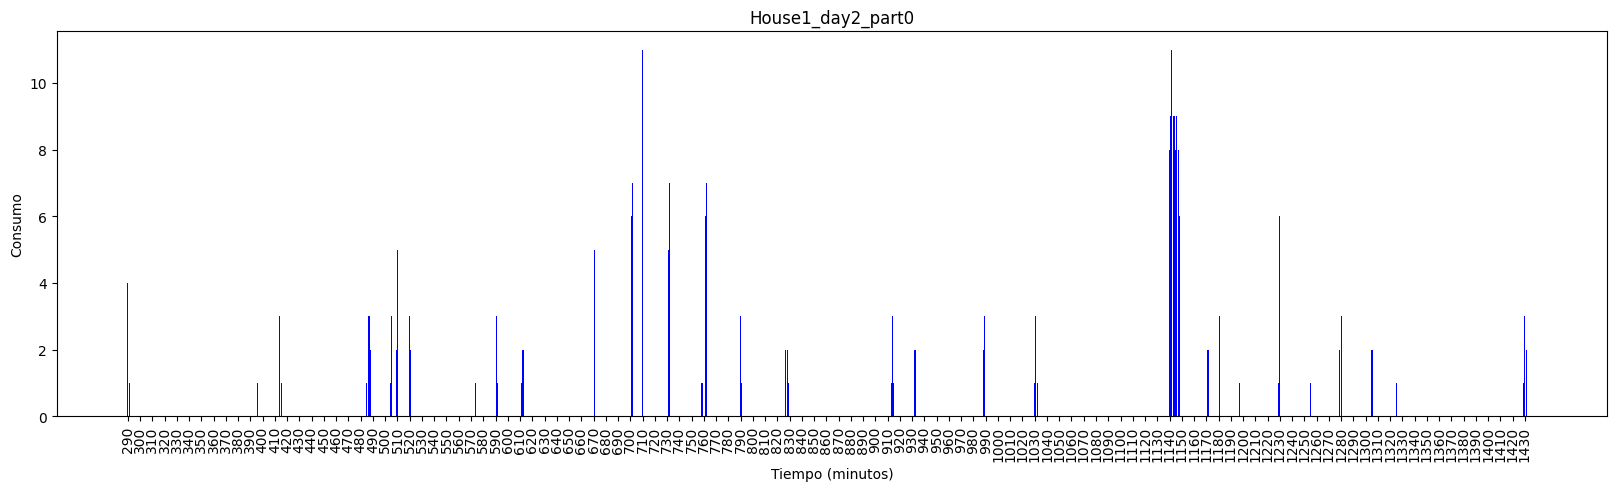

In [36]:
consumo_ejemplo = next(consumo for consumo in consumos_simulados.get_consumos() if max(consumo.get_serie()) > 7 and sum(consumo.get_serie()) > 150)
consumo_ejemplo = consumos_simulados.get_consumo(1, "House10")
consumo_ejemplo = consumos_simulados.get_consumos()[1]

inicio = 290
fin = 1440
intervalo = 10
serie_ejemplo = consumo_ejemplo.get_serie()[inicio:fin]

plt.figure(figsize=(20, 5))
plt.bar(range(inicio, fin), serie_ejemplo, color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title(consumo_ejemplo.obtener_id())
plt.xticks(range(inicio, fin, intervalo), rotation=90)
plt.show()


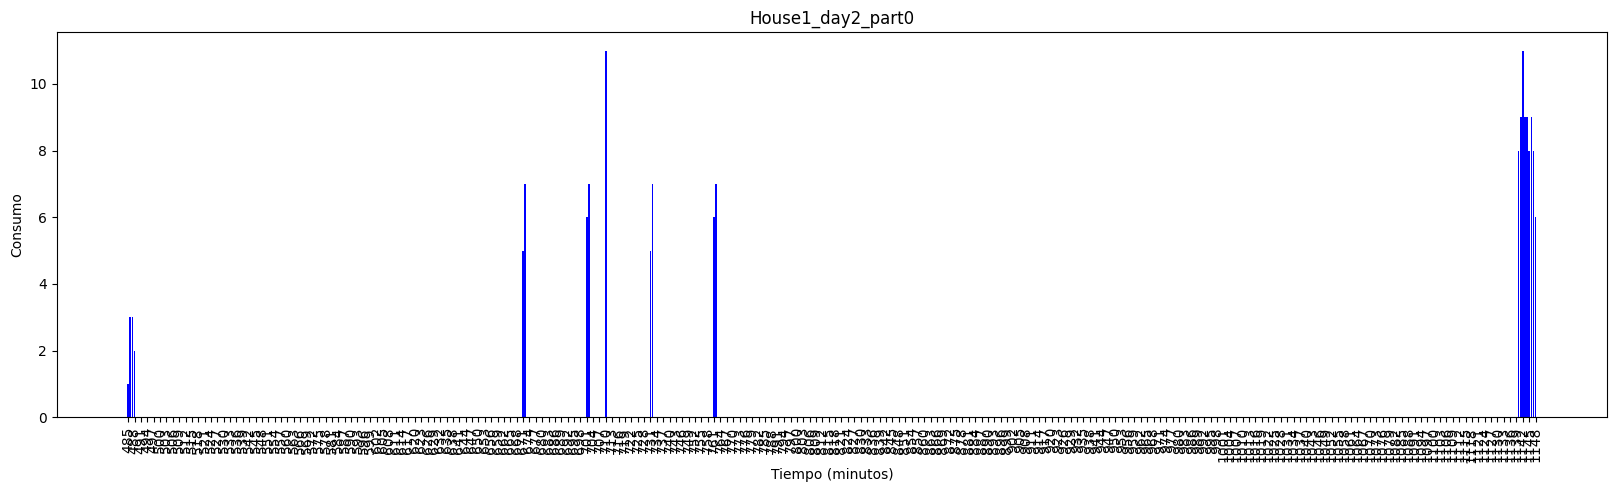

In [37]:
eventos = consumo_ejemplo.obtener_lista_eac()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio
fin = len(serie_ejemplo) + inicio
intervalo = 3

plt.figure(figsize=(20, 5))
plt.bar(range(inicio, fin), serie_ejemplo, color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title(consumo_ejemplo.obtener_id())
plt.xticks(range(inicio, fin, intervalo), rotation=90)
plt.show()


In [ ]:
for e in eventos:
  print(e.__dict__())

{'id': '9301f6b4-657d-4e6d-854d-b38c2c8f6dd3', 'min_inicio': 290, 'min_fin': 292, 'serie': [4, 1], 'consumo_origen': 'House1_day2_part0'}
{'id': '46c449db-e858-4344-99a6-081ee84c1108', 'min_inicio': 396, 'min_fin': 397, 'serie': [1], 'consumo_origen': 'House1_day2_part0'}
{'id': '7903f362-74ae-4f0e-93fa-4dff33dce18b', 'min_inicio': 414, 'min_fin': 416, 'serie': [3, 1], 'consumo_origen': 'House1_day2_part0'}
{'id': '7ae98213-9557-4c68-9d7a-9fccd790e8a9', 'min_inicio': 485, 'min_fin': 489, 'serie': [1, 3, 3, 2], 'consumo_origen': 'House1_day2_part0'}
{'id': 'a00c3512-0809-409e-af37-8d13ca24ce08', 'min_inicio': 504, 'min_fin': 506, 'serie': [1, 3], 'consumo_origen': 'House1_day2_part0'}
{'id': '989bc523-7014-40c0-82cf-bf01f47da148', 'min_inicio': 509, 'min_fin': 511, 'serie': [2, 5], 'consumo_origen': 'House1_day2_part0'}
{'id': 'f9852a53-aaa0-4d0a-a6b5-f56cb6fa74ec', 'min_inicio': 520, 'min_fin': 522, 'serie': [3, 2], 'consumo_origen': 'House1_day2_part0'}
{'id': '3eb4675f-6869-4d64-beb3

Una serie temporal para cada grupo de eventos según su consumo:
- De alto consumo
- De bajo consumo

# Code testing

In [ ]:
e = Evento(2, Consumo(0, "Test"), [1, 2])
r = construir_serie_desde_eventos([e], False)
len(r)

In [ ]:
localizar_repeticiones(serie_ejemplo, 0, 10)

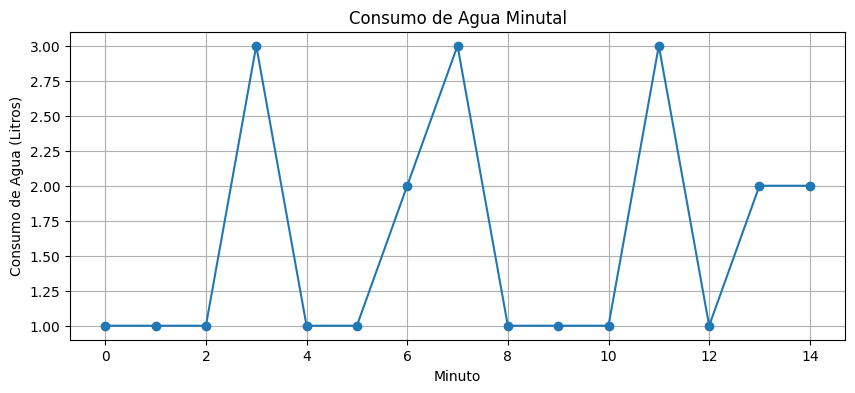

<Figure size 1000x400 with 0 Axes>

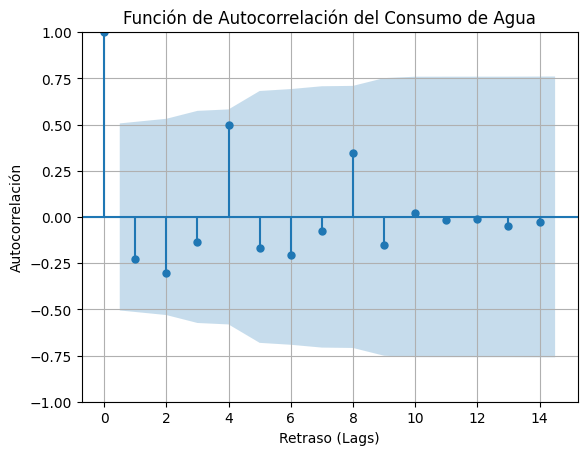

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

serie_ejemplo = [1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 3, 1, 2, 2]
inicio = 0
fin = len(serie_ejemplo)

plt.figure(figsize=(10, 4))
plt.plot(serie_ejemplo, marker='o')
plt.title('Consumo de Agua Minutal')
plt.xlabel('Minuto')
plt.ylabel('Consumo de Agua (Litros)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(serie_ejemplo, lags=(fin - inicio - 1))
plt.title('Función de Autocorrelación del Consumo de Agua')
plt.xlabel('Retraso (Lags)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()



In [ ]:
localizar_repeticiones(serie_ejemplo, 0, 10)

[(29, 29), (59, 30), (90, 31)]

In [ ]:
from statsmodels.tsa.stattools import acf
autocorr, conf_int = acf(serie_ejemplo, nlags=(fin - inicio - 1), alpha=0.05)
lowers = []
for lower, upper in conf_int[3:]:
  lowers.append(lower)
media_lowers = np.mean(lowers)
umbral_significativo = media_lowers + np.std(lowers)  # Umbral basado en la media y desviación estándar
print(umbral_significativo)

-0.4762921770150438


In [ ]:
print("Autocorrelación e Intervalos de Confianza:")
for lag, val, (lower, upper) in zip(range(len(autocorr)), autocorr, conf_int):
    print(f"Lag {lag}: {val:.3f}, Intervalo de Confianza: ({lower:.3f}, {upper:.3f})")

Autocorrelación e Intervalos de Confianza:
Lag 0: 1.000, Intervalo de Confianza: (1.000, 1.000)
Lag 1: -0.225, Intervalo de Confianza: (-0.731, 0.281)
Lag 2: -0.304, Intervalo de Confianza: (-0.835, 0.227)
Lag 3: -0.133, Intervalo de Confianza: (-0.707, 0.441)
Lag 4: 0.496, Intervalo de Confianza: (-0.086, 1.078)
Lag 5: -0.167, Intervalo de Confianza: (-0.848, 0.515)
Lag 6: -0.204, Intervalo de Confianza: (-0.896, 0.488)
Lag 7: -0.075, Intervalo de Confianza: (-0.782, 0.632)
Lag 8: 0.346, Intervalo de Confianza: (-0.363, 1.055)
Lag 9: -0.150, Intervalo de Confianza: (-0.901, 0.601)
Lag 10: 0.021, Intervalo de Confianza: (-0.738, 0.780)
Lag 11: -0.017, Intervalo de Confianza: (-0.776, 0.742)
Lag 12: -0.012, Intervalo de Confianza: (-0.771, 0.746)
Lag 13: -0.050, Intervalo de Confianza: (-0.809, 0.709)
Lag 14: -0.025, Intervalo de Confianza: (-0.785, 0.735)


In [ ]:
# Decisión sobre la repetición basada en la autocorrelación
def hay_repeticion(autocorr, umbral=0.2):
    for lag, val in enumerate(autocorr):
        if lag != 0 and abs(val) > umbral:
            return True, lag
    return False, None

umbral_autocorrelacion = 0.2
repeticion, lag = hay_repeticion(autocorr, umbral_autocorrelacion)

if repeticion:
    print(f"Se detectó una repetición significativa en el lag {lag}.")
else:
    print("No se detectaron repeticiones significativas.")


Se detectó una repetición significativa en el lag 1.


# Series Reales

In [ ]:
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 4, 2, 1, 4, 2, 6, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 4, 5, 3, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 1, 0, 0, 0, 0, 0, 0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 6, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
serie_real[1382:1398]

[0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]

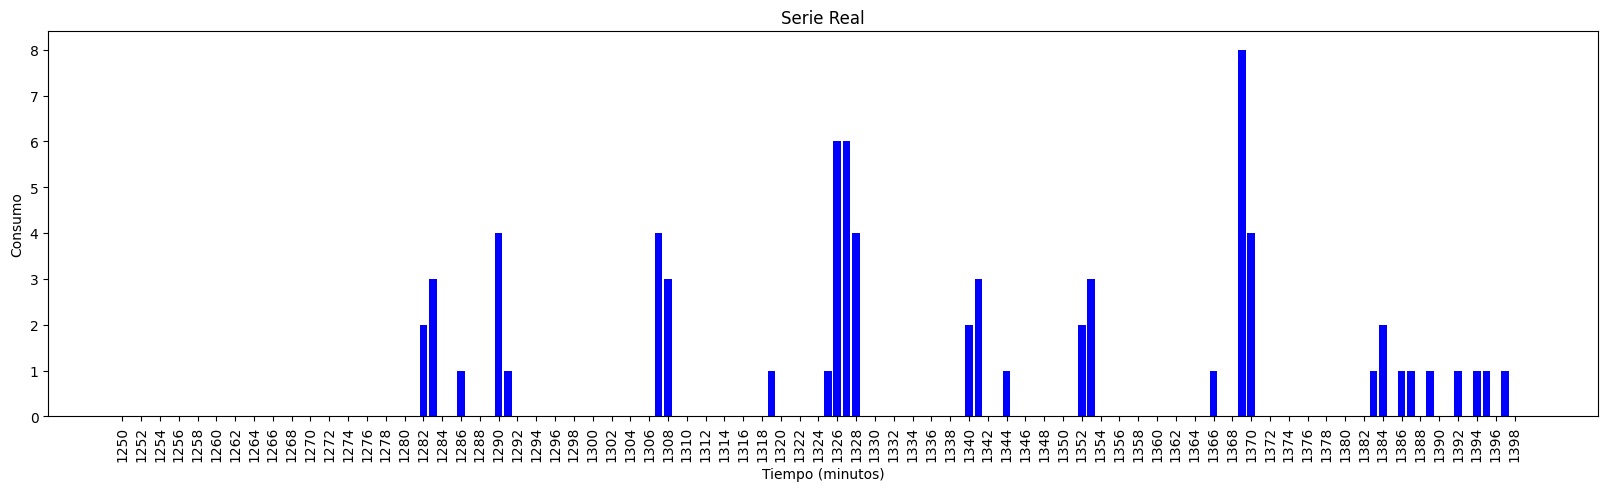

In [ ]:
inicio = 1250
fin = 1400
plt.figure(figsize=(20, 5))  # Tamaño de la figura
plt.bar(range(inicio, fin), serie_real[inicio:fin], color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title(f'Serie Real')
plt.xticks(range(inicio, fin, 2), rotation=90)
plt.show()

In [ ]:
localizar_repeticiones(serie_real[1282:fin], 0, 10)

[(14, 14), (25, 11), (41, 16), (61, 20), (79, 18)]

In [ ]:
# serie_consumo = []
# ultimo_min_fin = 0
# for e in serie_eventos:
#   serie_consumo += [0]*(e["start"] - ultimo_min_fin) + e["serie"]
#   ultimo_min_fin = e["end"] + 1
# serie_consumo += [0]* (1440 - ultimo_min_fin)
# print(serie_consumo)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# NOTAS

- Para que haya discontinuidad en un evento continuo el consumo debe ser menor a 1 L/minuto.
- No es de interés identificar los consumos de menos de 1 L/minuto.
- Primera pasada: obtener todos los eventos entre c = 0.